### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

In [3]:
df = pd.read_csv(r"C:\Users\dines\Downloads\reviews_data_dump\reviews_badminton\data.csv")
df.head()

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",4
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,1
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,1
3,Suresh Narayanasamy,Fair,"Certified Buyer, Chennai",25.0,1.0,NaN,"Quite O. K. , but nowadays the quality of the...",3
4,ASHIK P A,Over priced,NaN,147.0,24.0,Apr 2016,Over pricedJust â?¹620 ..from retailer.I didn'...,1


In [4]:
df.shape

(8518, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8518 entries, 0 to 8517
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Reviewer Name    8508 non-null   object 
 1   Review Title     8508 non-null   object 
 2   Place of Review  8468 non-null   object 
 3   Up Votes         8508 non-null   float64
 4   Down Votes       8508 non-null   float64
 5   Month            8053 non-null   object 
 6   Review text      8510 non-null   object 
 7   Ratings          8518 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 532.5+ KB


In [5]:
df.isnull().sum()

Reviewer Name       10
Review Title        10
Place of Review     50
Up Votes            10
Down Votes          10
Month              465
Review text          8
Ratings              0
dtype: int64

In [7]:
df.dropna(axis=0,inplace=True)

In [8]:
df.isnull().sum()

Reviewer Name      0
Review Title       0
Place of Review    0
Up Votes           0
Down Votes         0
Month              0
Review text        0
Ratings            0
dtype: int64

<Axes: xlabel='Ratings', ylabel='count'>

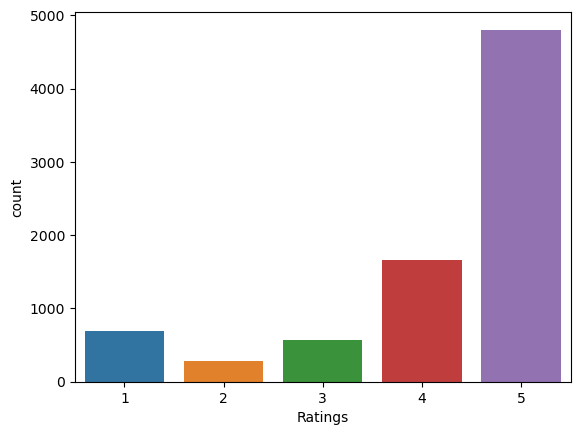

In [9]:
sns.countplot(x='Ratings',data=df)

In [10]:
def replace_ratings(value):
    if value == 1 or value == 2 or value==3:
        return 'negative'
    else :
        return 'positive'
    
    return value
df['Ratings'] = df['Ratings'].apply(replace_ratings)

In [11]:
df['Ratings'].unique()

array(['positive', 'negative'], dtype=object)

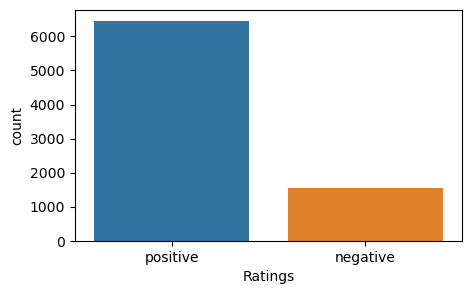

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 3)) 
sns.countplot(x='Ratings', data=df)
plt.show()

In [13]:
df['Review text'] = df['Review text'].str.replace('READ MORE', '')

In [14]:
X=df[['Review text']]
y=df['Ratings']

In [15]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.75,random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(6009, 1) (6009,)
(2004, 1) (2004,)


In [16]:
stemmer=PorterStemmer()

In [17]:
lemmatizer=WordNetLemmatizer()

In [18]:
def preprocess(text):
    sentence = re.sub(r'[^a-zA-Z]', ' ', text)
    #lower case
    sentence = sentence.lower()
    # tokenize
    tokens = sentence.split()
    # remove stopwords
    c_tokens = [token for token in tokens if token not in stopwords.words("english")]
    # lemmatization
    c_tokens = [lemmatizer.lemmatize(token) for token in c_tokens]
    return pd.Series(' '.join(c_tokens))

In [19]:
X_train.head()

,Review text
6808,i can't rate it. its too High price than offli...
8262,Shuttle is v Gud at v nice price. V durable
4446,Good quality original shuttle
4366,Good...
4376,Best experience


In [20]:
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

In [21]:
X_train_tran= X_train['Review text'].progress_apply(lambda x: preprocess(x))
X_train_tran.head()

100%|█████████████████████████████████████████████████████████████████████████████| 6009/6009 [00:08<00:00, 709.54it/s]


,0
6808,rate high price offline
8262,shuttle v gud v nice price v durable
4446,good quality original shuttle
4366,good
4376,best experience


In [22]:
X_train_tran.columns = ['Clean_reviewtext']
X_train_tran.head()

,Clean_reviewtext
6808,rate high price offline
8262,shuttle v gud v nice price v durable
4446,good quality original shuttle
4366,good
4376,best experience


In [23]:
X_train_tran.shape

(6009, 1)

In [24]:
X_test.head()

,Review text
3350,I bought it for 419 in flipkart I totally boug...
2414,As expected
6751,good
8367,Nice
5773,good as of now


In [25]:
X_test_tran= X_test['Review text'].progress_apply(lambda x: preprocess(x))
X_test_tran.head()

100%|█████████████████████████████████████████████████████████████████████████████| 2004/2004 [00:02<00:00, 887.02it/s]


,0
3350,bought flipkart totally bought price
2414,expected
6751,good
8367,nice
5773,good


In [26]:
X_test_tran.columns = ['Clean_reviewtext']
X_test_tran.head()

,Clean_reviewtext
3350,bought flipkart totally bought price
2414,expected
6751,good
8367,nice
5773,good


### Bag of Words

In [27]:
vect = CountVectorizer()
X_train_bow = vect.fit_transform(X_train_tran['Clean_reviewtext'])
X_train_bow.shape

(6009, 2111)

In [28]:
X_test_bow = vect.transform(X_test_tran['Clean_reviewtext'])
X_test_bow.shape

(2004, 2111)

### Model Training

### Naive Bayes

In [29]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [30]:
%time nb.fit(X_train_bow,y_train)

CPU times: total: 0 ns
Wall time: 14.6 ms


MultinomialNB()

In [31]:
y_train_pred = nb.predict(X_train_bow)
y_test_pred = nb.predict(X_test_bow)

In [32]:
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, precision_score, recall_score, f1_score

In [33]:
print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))

Train accuracy:  0.9011482775836246
Test accuracy:  0.8707584830339321


In [34]:
print('F1 Score - Train:', f1_score(y_train, y_train_pred, average='weighted'))
print('F1 Score - Test:', f1_score(y_test, y_test_pred, average='weighted'))

F1 Score - Train: 0.8933407173024108
F1 Score - Test: 0.8580362121615684


In [35]:
from sklearn import metrics
metrics.confusion_matrix(y_train, y_train_pred)

array([[ 662,  484],
       [ 110, 4753]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

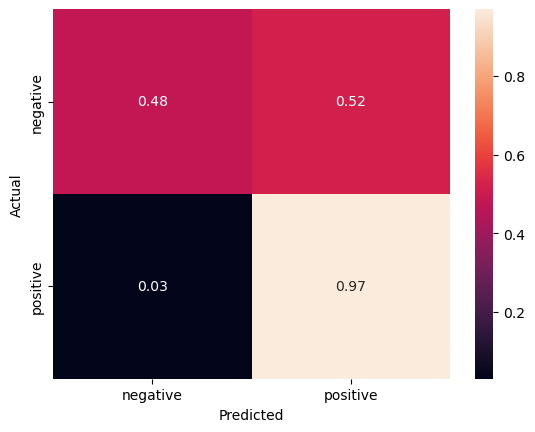

In [36]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=nb.classes_, yticklabels=nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Logistic

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
lr = LogisticRegression()
%time lr.fit(X_train_bow,y_train)

CPU times: total: 15.6 ms
Wall time: 49.4 ms


LogisticRegression()

In [39]:
y_train_pred = lr.predict(X_train_bow)
y_test_pred = lr.predict(X_test_bow)

In [40]:
print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))
print('F1 Score - Train:', f1_score(y_train, y_train_pred, average='weighted'))
print('F1 Score - Test:', f1_score(y_test, y_test_pred, average='weighted'))

Train accuracy:  0.9108004659677151
Test accuracy:  0.8822355289421158
F1 Score - Train: 0.9029375270259502
F1 Score - Test: 0.8703539349871685


Text(0.5, 23.52222222222222, 'Predicted')

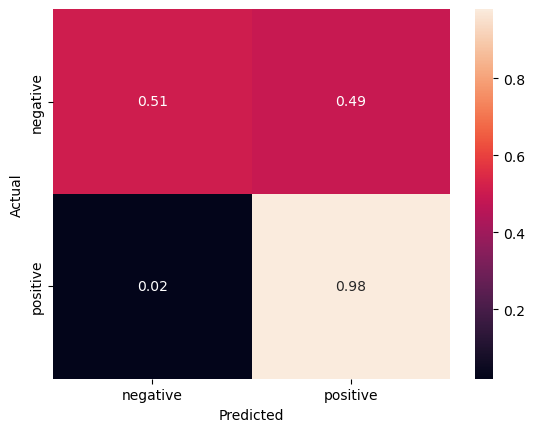

In [41]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=lr.classes_, yticklabels=lr.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### KNN

In [42]:
from sklearn.neighbors import KNeighborsClassifier

In [43]:
knn = KNeighborsClassifier()
%time knn.fit(X_train_bow,y_train)

CPU times: total: 0 ns
Wall time: 5.91 ms


KNeighborsClassifier()

In [44]:
y_train_pred = knn.predict(X_train_bow)
y_test_pred = knn.predict(X_test_bow)

In [45]:
print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))
print('F1 Score - Train:', f1_score(y_train, y_train_pred, average='weighted'))
print('F1 Score - Test:', f1_score(y_test, y_test_pred, average='weighted'))

Train accuracy:  0.8856714927608587
Test accuracy:  0.8622754491017964
F1 Score - Train: 0.8753719513694096
F1 Score - Test: 0.8490524817657197


Text(0.5, 23.52222222222222, 'Predicted')

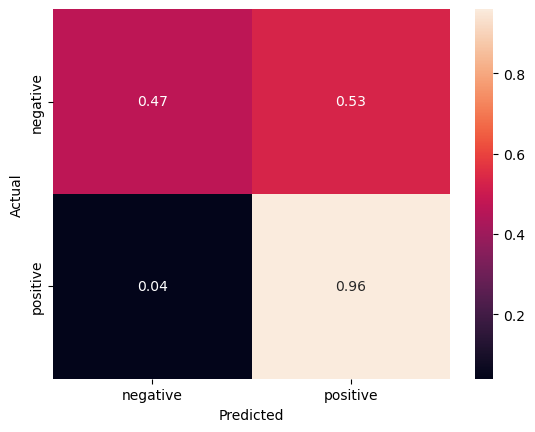

In [46]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Decision tree

In [47]:
from sklearn.tree import DecisionTreeClassifier

In [48]:
dt = DecisionTreeClassifier()
%time dt.fit(X_train_bow,y_train)

CPU times: total: 156 ms
Wall time: 159 ms


DecisionTreeClassifier()

In [49]:
y_train_pred = dt.predict(X_train_bow)
y_test_pred = dt.predict(X_test_bow)

In [50]:
print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))
print('F1 Score - Train:', f1_score(y_train, y_train_pred, average='weighted'))
print('F1 Score - Test:', f1_score(y_test, y_test_pred, average='weighted'))

Train accuracy:  0.9532368114494925
Test accuracy:  0.841816367265469
F1 Score - Train: 0.9514626524021284
F1 Score - Test: 0.8382613887423497


In [51]:
metrics.confusion_matrix(y_test, y_test_pred)

array([[ 224,  181],
       [ 136, 1463]], dtype=int64)

Text(0.5, 23.52222222222222, 'Predicted')

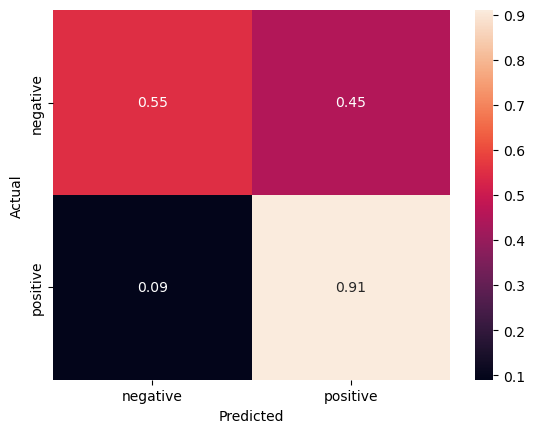

In [52]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=dt.classes_, yticklabels=dt.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Random forest

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
rf = RandomForestClassifier()
%time rf.fit(X_train_bow,y_train)

CPU times: total: 2.77 s
Wall time: 2.83 s


RandomForestClassifier()

In [55]:
y_train_pred = rf.predict(X_train_bow)
y_test_pred = rf.predict(X_test_bow)

In [56]:
print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))
print('F1 Score - Train:', f1_score(y_train, y_train_pred, average='weighted'))
print('F1 Score - Test:', f1_score(y_test, y_test_pred, average='weighted'))

Train accuracy:  0.9530703944083874
Test accuracy:  0.8662674650698603
F1 Score - Train: 0.9510364389597176
F1 Score - Test: 0.8570568588430498


Text(0.5, 23.52222222222222, 'Predicted')

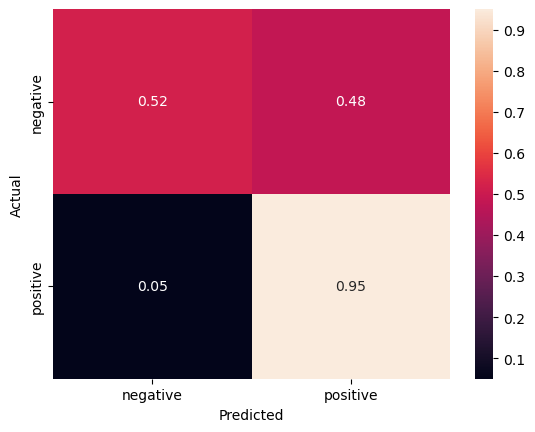

In [57]:
cm = metrics.confusion_matrix(y_test, y_test_pred)
actual = np.sum(cm, axis=1).reshape(-1, 1)
cmn = np.round(cm/actual, 2)

sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')

### Logistics classification model

In [58]:
import joblib

In [59]:
filename = "lr.pkl"
joblib.dump(lr, filename)

['lr.pkl']

In [60]:
model = joblib.load('lr.pkl')

In [61]:
filename = "vectorizer.pkl"
joblib.dump(vect, filename)

['vectorizer.pkl']

In [62]:
df

,Reviewer Name,Review Title,Place of Review,Up Votes,Down Votes,Month,Review text,Ratings
0,Kamal Suresh,Nice product,"Certified Buyer, Chirakkal",889.0,64.0,Feb 2021,"Nice product, good quality, but price is now r...",positive
1,Flipkart Customer,Don't waste your money,"Certified Buyer, Hyderabad",109.0,6.0,Feb 2021,They didn't supplied Yonex Mavis 350. Outside ...,negative
2,A. S. Raja Srinivasan,Did not meet expectations,"Certified Buyer, Dharmapuri",42.0,3.0,Apr 2021,Worst product. Damaged shuttlecocks packed in ...,negative
5,Baji Sankar,Mind-blowing purchase,"Certified Buyer, Hyderabad",173.0,45.0,Oct 2018,Good quality product. Delivered on time.,positive
6,Flipkart Customer,Must buy!,"Certified Buyer, Doom Dooma",403.0,121.0,Jan 2020,BEST PURCHASE It is a good quality and is more...,positive
...,...,...,...,...,...,...,...,...
8495,vishal kumar ashish,Nice,"Certified Buyer, Haridwar",0.0,0.0,Oct 2016,Thanks to the delivery boy ... Service is alwa...,positive
8496,Nitya Nand Rai,Good choice,"Certified Buyer, Raebareli",0.0,0.0,Oct 2016,Over priced even after 50% discount price is m...,negative
8497,Tarun Reddy,Awesome,Certified Buyer,0.0,0.0,Oct 2016,Too much priced. It was getting me for Rs. 640...,negative
8499,Jayachandra,High cost,"Certified Buyer, Mangalore",0.0,0.0,Dec 2015,Hii flipkart customers care..why your delivery...,positive


In [66]:
df['Review text'][8507]

'Nice delivery speed'